Dataset size: 999


Map:   0%|          | 0/999 [00:00<?, ? examples/s]

,file,genre,duration_sec,rms,pitch_mean,mel_energy
0,/home/sanchit/.cache/datasets/downloads/extrac...,0,30.013344,0.140688,117.355616,3.983238
1,/home/sanchit/.cache/datasets/downloads/extrac...,0,30.013344,0.107619,96.681430,2.349213
2,/home/sanchit/.cache/datasets/downloads/extrac...,0,30.013344,0.183227,90.413443,6.581287
3,/home/sanchit/.cache/datasets/downloads/extrac...,0,30.013344,0.162029,63.886043,5.633729
4,/home/sanchit/.cache/datasets/downloads/extrac...,0,30.013344,0.103356,164.308805,1.914774


Original samples: 999
Clean samples: 999


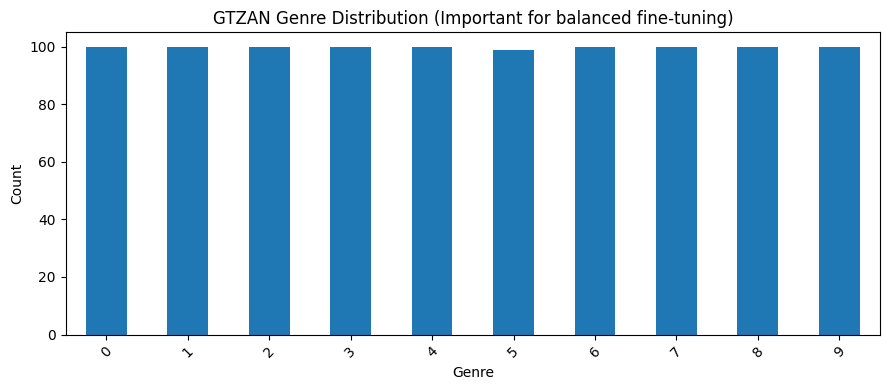

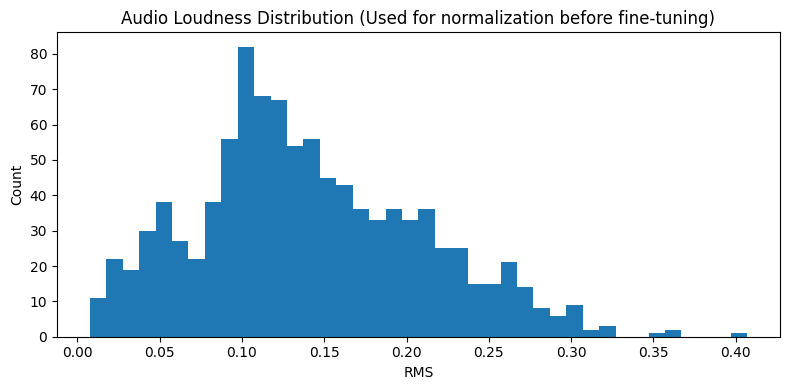

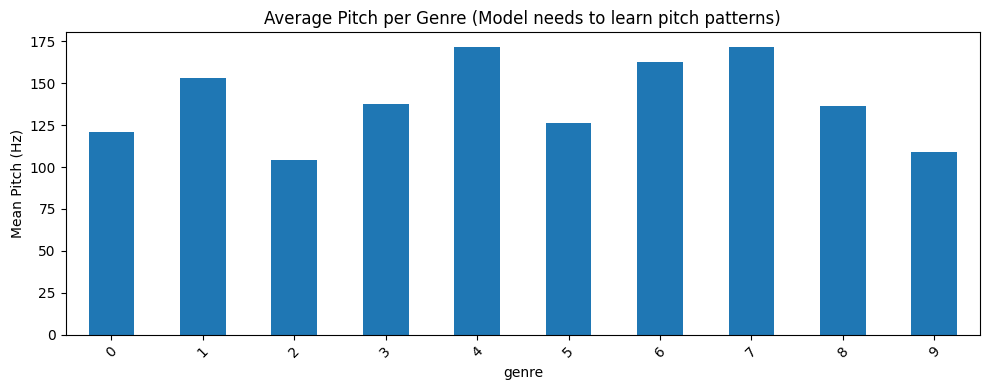

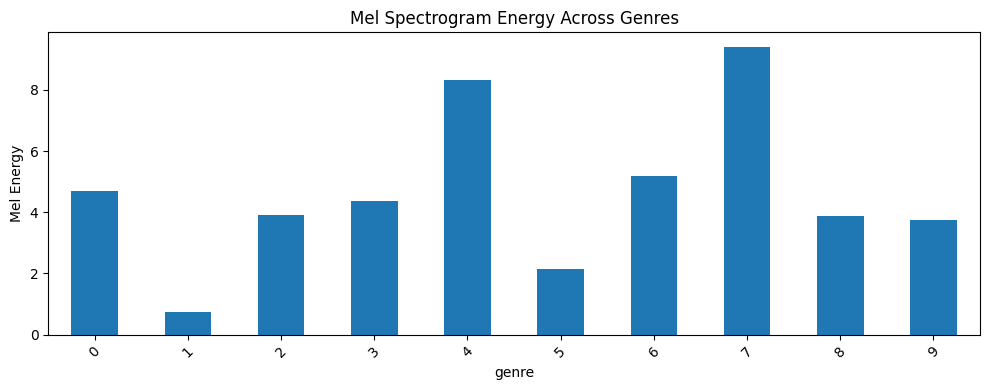

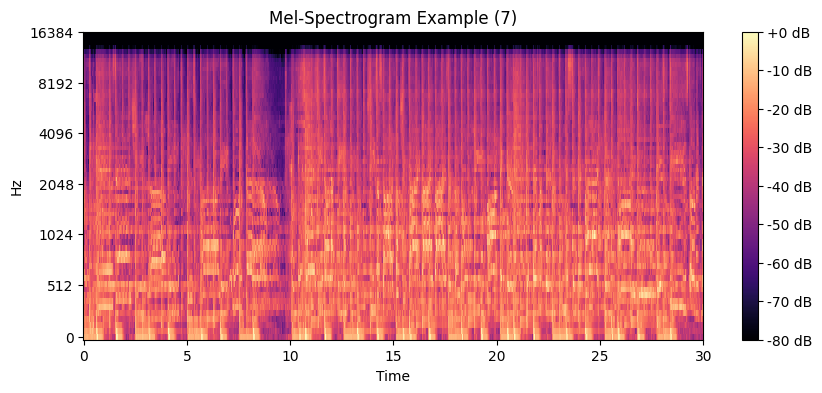

In [6]:
# ==========================================
# GTZAN ANALYTICS FOR MODEL FINETUNING
# ==========================================

!pip install datasets librosa matplotlib pandas numpy

import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from IPython.display import display

# --------------------------
# 1. Load dataset
# --------------------------
ds = load_dataset("sanchit-gandhi/gtzan", split="train")
label_col = "genre"

print("Dataset size:", len(ds))


# --------------------------
# 2. Compute duration, RMS, pitch & mel features
# --------------------------
def extract_features(ex):
    y = ex["audio"]["array"]
    sr = ex["audio"]["sampling_rate"]

    # Duration
    ex["duration_sec"] = len(y) / sr

    # Loudness (RMS)
    ex["rms"] = float(np.sqrt(np.mean(y**2)))

    # Pitch estimate (YIN)
    try:
        pitch = librosa.yin(y, fmin=50, fmax=2000)
        ex["pitch_mean"] = float(np.mean(pitch))
    except:
        ex["pitch_mean"] = np.nan

    # Mel Spectrogram (used in fine-tuning preprocessing)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    ex["mel_energy"] = float(np.mean(mel))

    return ex

ds_features = ds.map(extract_features)

df = ds_features.remove_columns("audio").to_pandas()
display(df.head())


# --------------------------
# 3. CLEANING FOR FINETUNING
# --------------------------
df_clean = df[df["duration_sec"].between(25, 35)].reset_index(drop=True)

print("Original samples:", len(df))
print("Clean samples:", len(df_clean))


# --------------------------
# 4. GENRE DISTRIBUTION
# --------------------------
plt.figure(figsize=(9,4))
df_clean[label_col].value_counts().sort_index().plot(kind="bar")
plt.title("GTZAN Genre Distribution (Important for balanced fine-tuning)")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --------------------------
# 5. LOUDNESS / RMS DISTRIBUTION
# --------------------------
plt.figure(figsize=(8,4))
plt.hist(df_clean["rms"], bins=40)
plt.title("Audio Loudness Distribution (Used for normalization before fine-tuning)")
plt.xlabel("RMS")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# --------------------------
# 6. AVERAGE PITCH PER GENRE
# --------------------------
pitch_per_genre = df_clean.groupby(label_col)["pitch_mean"].mean()

plt.figure(figsize=(10,4))
pitch_per_genre.plot(kind="bar")
plt.title("Average Pitch per Genre (Model needs to learn pitch patterns)")
plt.ylabel("Mean Pitch (Hz)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --------------------------
# 7. MEL SPECTROGRAM ENERGY PER GENRE
# --------------------------
mel_genre = df_clean.groupby(label_col)["mel_energy"].mean()

plt.figure(figsize=(10,4))
mel_genre.plot(kind="bar")
plt.title("Mel Spectrogram Energy Across Genres")
plt.ylabel("Mel Energy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --------------------------
# 8. SAMPLE SPECTROGRAM (important for explaining preprocessing)
# --------------------------
import random

idx = random.choice(df_clean.index.tolist())
audio = ds[idx]["audio"]["array"]
sr = ds[idx]["audio"]["sampling_rate"]

S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=64)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10,4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel-Spectrogram Example ({df_clean.loc[idx, label_col]})")
plt.show()
